# 技术分析策略与交易系统——CCI指标的策略实现

In [1]:
import numpy as np
import pandas as pd
import talib as ta
import tushare as ts
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 确保可以显示‘-’号
mpl.rcParams['axes.unicode_minus']=False
# 确保中文显示正常
mpl.rcParams['font.sans-serif'] = ['SimHei']  

In [2]:
ts.set_token('2f78cab603efdeb7c22f1fa80343850981d7359de533636ba0006f45')
pro = ts.pro_api()

### 1.数据获取和数据处理

In [3]:
# 获得历史数据并按时间升序排序
stock = ts.get_k_data('600030', '2016-06-01', '2017-06-30')
stock.sort_index(inplace=True)
stock.head()

,date,open,close,high,low,volume,code
100,2016-06-01,15.584,15.380,15.723,15.371,1166959.0,600030
101,2016-06-02,15.380,15.408,15.510,15.241,771421.0,600030
102,2016-06-03,15.445,15.426,15.668,15.296,1154137.0,600030
103,2016-06-06,15.454,15.278,15.501,15.241,551761.0,600030
104,2016-06-07,15.324,15.306,15.445,15.250,594367.0,600030


In [4]:
# 计算CCI，取时间周期为20
stock['cci'] = ta.CCI(np.asarray(stock['high']), np.asarray(stock['low']), np.asarray(stock['close']), timeperiod=20)

In [5]:
stock.tail()

,date,open,close,high,low,volume,code,cci
358,2017-06-26,16.186,16.492,16.635,16.148,2113195.0,600030,230.595412
359,2017-06-27,16.482,16.349,16.511,16.301,924024.0,600030,172.265829
360,2017-06-28,16.320,16.330,16.502,16.253,871050.0,600030,135.393934
361,2017-06-29,16.320,16.330,16.425,16.224,668341.0,600030,107.889013
362,2017-06-30,16.263,16.263,16.349,16.072,751091.0,600030,73.801898


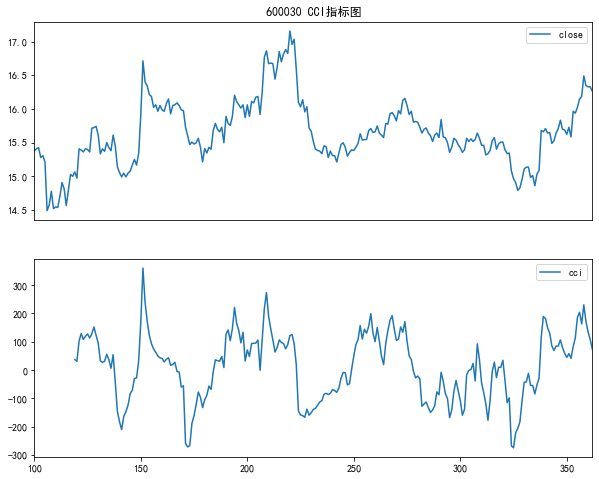

In [6]:
# 绘制cci指标图
plt.subplot(2, 1, 1)
plt.title('600030 CCI指标图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (10,8))
plt.legend()
plt.subplot(2, 1, 2)
stock['cci'].plot(figsize = (10,8))
plt.legend()
plt.show()

### 2. 交易信号和策略逻辑

#### 2.1 产生交易信号；

In [7]:
# 产生开仓信号时应使用昨日及前日cci，以避免未来数据
stock['yes_cci'] = stock['cci'].shift(1)
stock['daybeforeyes_cci'] = stock['cci'].shift(2)

In [8]:
# 产生开平仓信号
# 开多信号：当前二日cci小于-100，昨日cci大于-100则记为开多信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci'] < -100, stock['yes_cci'] > -100), 1, 0)
# 开空信号：当前二日cci大于100， 昨日cci小于100则记为开空信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci'] > 100, stock['yes_cci'] < 100), -1, stock['signal'])

In [9]:
stock.tail()

,date,open,close,high,low,volume,code,cci,yes_cci,daybeforeyes_cci,signal
358,2017-06-26,16.186,16.492,16.635,16.148,2113195.0,600030,230.595412,163.336361,204.395199,0
359,2017-06-27,16.482,16.349,16.511,16.301,924024.0,600030,172.265829,230.595412,163.336361,0
360,2017-06-28,16.320,16.330,16.502,16.253,871050.0,600030,135.393934,172.265829,230.595412,0
361,2017-06-29,16.320,16.330,16.425,16.224,668341.0,600030,107.889013,135.393934,172.265829,0
362,2017-06-30,16.263,16.263,16.349,16.072,751091.0,600030,73.801898,107.889013,135.393934,0


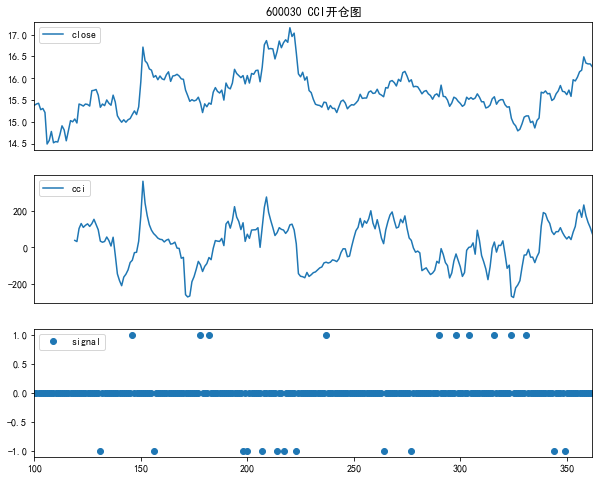

In [10]:
plt.subplot(3, 1, 1)
plt.title('600030 CCI开仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (10,8))
plt.legend(loc='upper left')
plt.subplot(3, 1, 2)
stock['cci'].plot(figsize = (10,8))
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)
plt.subplot(3, 1, 3)
stock['signal'].plot(figsize = (10,8),marker='o',linestyle='')

plt.legend(loc='upper left')
plt.show()

In [11]:
# 如果当天没有交易信号，设置为nan，如果有，取原来信号
stock['signal'] = np.where(stock['signal']==0, np.nan, stock['signal'])
# 通过前向填充生成持仓记录
stock['position'] = stock['signal'].fillna(method='ffill')

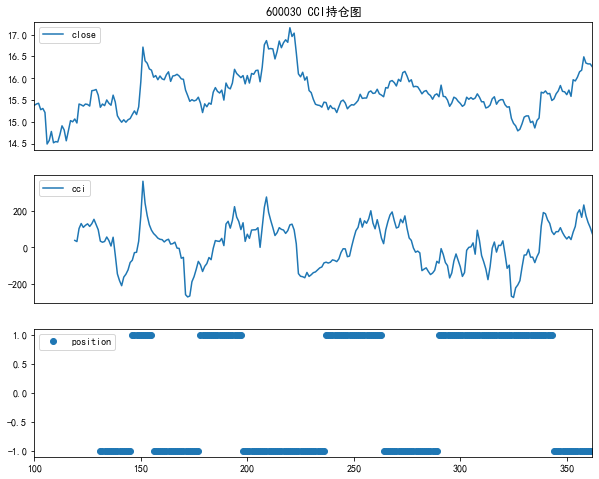

In [12]:
plt.subplot(3, 1, 1)
plt.title('600030 CCI持仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (12,12))
plt.legend(loc='upper left')
plt.subplot(3, 1, 2)
stock['cci'].plot(figsize = (12,12))
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)
plt.subplot(3, 1, 3)
stock['position'].plot(marker='o', figsize=(10,8),linestyle='')
plt.legend(loc='upper left')
plt.show()

### 3. 收益计算和净值绘制

In [13]:
# 计算策略收益
# 计算股票每日收益率
stock['pct_change'] = stock['close'].pct_change()
# 计算策略每日收益率
stock['strategy_return'] = stock['pct_change'] * stock['position']
# 计算股票累积收益率
stock['return'] = (stock['pct_change']+1).cumprod()
# 计算策略累积收益率
stock['strategy_cum_return'] = (1 + stock['strategy_return']).cumprod()

In [14]:
stock.head()

,date,open,close,high,low,volume,code,cci,yes_cci,daybeforeyes_cci,signal,position,pct_change,strategy_return,return,strategy_cum_return
100,2016-06-01,15.584,15.380,15.723,15.371,1166959.0,600030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,2016-06-02,15.380,15.408,15.510,15.241,771421.0,600030,NaN,NaN,NaN,NaN,NaN,0.001821,NaN,1.001821,NaN
102,2016-06-03,15.445,15.426,15.668,15.296,1154137.0,600030,NaN,NaN,NaN,NaN,NaN,0.001168,NaN,1.002991,NaN
103,2016-06-06,15.454,15.278,15.501,15.241,551761.0,600030,NaN,NaN,NaN,NaN,NaN,-0.009594,NaN,0.993368,NaN
104,2016-06-07,15.324,15.306,15.445,15.250,594367.0,600030,NaN,NaN,NaN,NaN,NaN,0.001833,NaN,0.995189,NaN


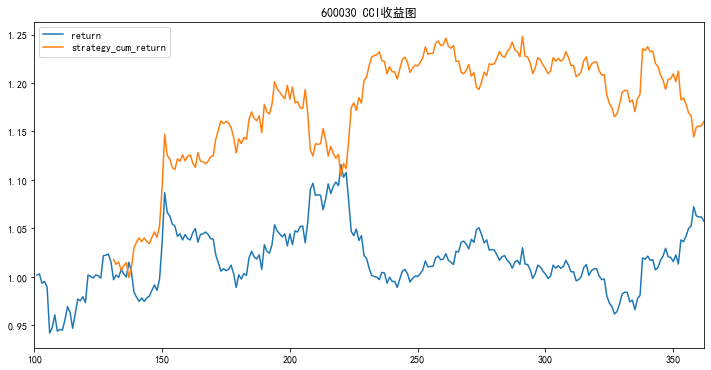

In [15]:
# 将股票累积收益率和策略累积收益率绘图
stock[['return', 'strategy_cum_return']].plot(figsize = (12,6))

plt.title('600030 CCI收益图')
plt.legend(loc='upper left')
plt.show()